In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

2021-11-20 21:02:42.533041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(tf.__version__, tf.config.list_physical_devices())

2.1.0 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2021-11-20 21:03:02.670434: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-20 21:03:02.790200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:1d:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-20 21:03:02.791059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 1 with properties: 
pciBusID: 0000:1e:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-11-20 21:03:02.791109: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-20 21:03:02.890939: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.

In [3]:
labels = pd.read_csv('new_csv.txt')

In [4]:
# create a data generator
datagen = ImageDataGenerator(validation_split=0.1)
# load and iterate training dataset
train_it = datagen.flow_from_directory(
    '../master-data/train_small/rgb', 
    target_size=(256, 256),
    subset="training", 
    class_mode="sparse",
    color_mode="grayscale",
    batch_size=32)

val_it = datagen.flow_from_directory(
    '../master-data/train_small/rgb', 
    target_size=(256, 256), 
    subset="validation", 
    class_mode="sparse",
    color_mode="grayscale",
    batch_size=32)

Found 27006 images belonging to 11 classes.
Found 3000 images belonging to 11 classes.


In [5]:
train_it.class_indices

{'AcrimSat': 0,
 'Aquarius': 1,
 'Aura': 2,
 'Calipso': 3,
 'Cloudsat': 4,
 'CubeSat': 5,
 'Debris': 6,
 'Jason': 7,
 'Sentinel-6': 8,
 'TRMM': 9,
 'Terra': 10}

In [6]:
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchy.shape, batchy.min(), batchy.max()))

Batch shape=(32, 256, 256, 1), min=0.000, max=255.000
Batch shape=(32,), min=0.000, max=10.000


In [11]:
# Initialising the CNN
model = Sequential()
# Convolution
model.add(Conv2D(32, (3, 3), input_shape = (256, 256, 1), activation = 'relu'))
# Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))
# Convolution
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 1), activation = 'relu'))
# Flattening
model.add(Flatten())
# Full connection
model.add(Dense(units = 128, activation = 'relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.5))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 11, activation = 'softmax'))
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
flatten_3 (Flatten)          (None, 500000)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               64000128  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [12]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_cnn.h5', save_best_only=True)
# Fitting the model
classifier = model.fit_generator(train_it,
                         epochs = 40,
                         validation_data = val_it,    
                         callbacks=[early_stop, model_checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 844 steps, validate for 94 steps
Epoch 1/40


2021-11-20 21:05:17.628894: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


844/844 [==============================] - 1703s 2s/step - loss: 6.5842 - accuracy: 0.1813 - val_loss: 2.3455 - val_accuracy: 0.2113
Epoch 2/40
844/844 [==============================] - 1719s 2s/step - loss: 2.0630 - accuracy: 0.2642 - val_loss: 2.4350 - val_accuracy: 0.2493
Epoch 3/40
844/844 [==============================] - 1653s 2s/step - loss: 1.8138 - accuracy: 0.3616 - val_loss: 2.6877 - val_accuracy: 0.2687
Epoch 4/40
844/844 [==============================] - 1685s 2s/step - loss: 1.4845 - accuracy: 0.4815 - val_loss: 2.6728 - val_accuracy: 0.3023
Epoch 5/40
844/844 [==============================] - 1739s 2s/step - loss: 1.2190 - accuracy: 0.5757 - val_loss: 2.6446 - val_accuracy: 0.2870
Epoch 00005: early stopping


In [13]:
# save the model
model.save("my_model")
print("Saved model to disk")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2021-11-20 23:26:57.821655: W tensorflow/python/util/util.cc:319] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: my_model/assets
Saved model to disk


In [14]:
df = pd.DataFrame(model.history.history)
df

,loss,accuracy,val_loss,val_accuracy
0,6.544078,0.181293,2.345460,0.211333
1,2.062965,0.264164,2.434974,0.249333
2,1.813846,0.361586,2.687722,0.268667
3,1.484486,0.481486,2.672754,0.302333
4,1.218989,0.575724,2.644624,0.287000


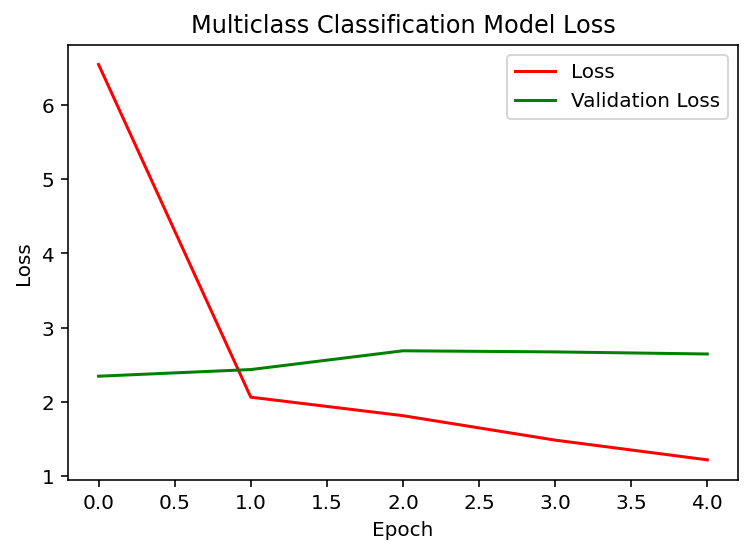

In [15]:
plt.plot(df['loss'], color='red', label='Loss')
plt.plot(df['val_loss'], color='green', label='Validation Loss')
plt.title('Multiclass Classification Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

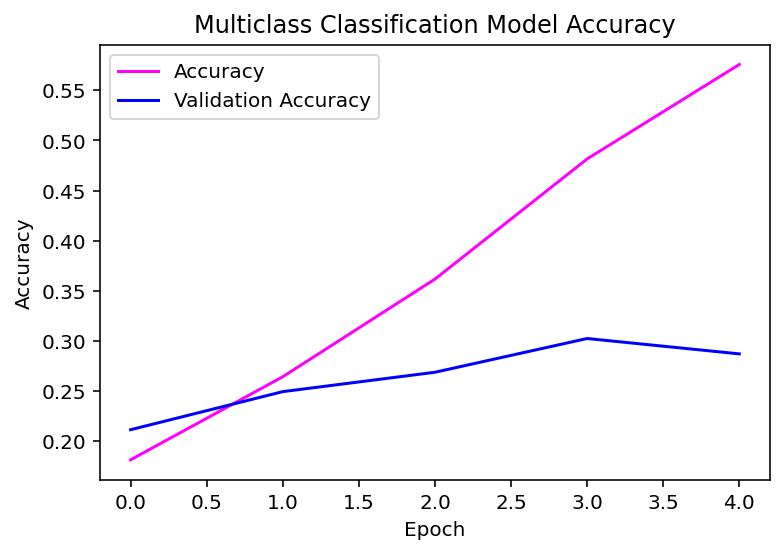

In [16]:
plt.plot(df['accuracy'], color='magenta', label='Accuracy')
plt.plot(df['val_accuracy'], color='blue', label='Validation Accuracy')
plt.title('Multiclass Classification Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()